In [33]:
import glob
import os 

import matplotlib.pyplot as plt
import pandas as pd

In [34]:
import files
import occupancy
import wait_times
import vehicles

# General Utils

In [35]:
SCENARIOS_PATH = r"E:/Files/CodeProjects/MATSim/Scenarios/"
RUN_DIR = "runner-tests/OneToFive.5"
PATH = os.path.join(SCENARIOS_PATH, RUN_DIR)


def fmt_timedelta(x):
    ts = x.total_seconds()
    hours, remainder = divmod(ts, 3600)
    minutes, _ = divmod(remainder, 60)
    return ('{:02d}:{:02d}').format(int(hours), int(minutes)) 


# Wait time utils

In [36]:
r = files.iterate_algorithms(PATH, wait_times.get_wait_stats)
pd.DataFrame(r).stack().unstack(level=-2)

output for RUN_ID: OneToFive.5, from func: get_wait_stats


,mean wait,95p wait
DRT,609.000000,1271.85
DynamicRideSharingStrategy,323.171875,593.10
ExtDemandSupplyBeamSharing,292.427500,601.30
HighCapacityDispatcher,549.753125,1567.05
TShareDispatcher,280.103125,595.00


# Population Utils

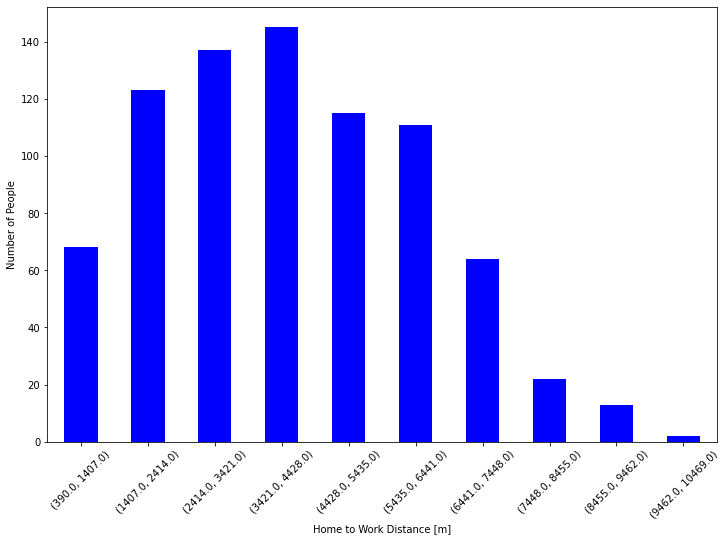

In [37]:
def get_origin_destination_data(alg_path):
    pop_filename = "Population*.xml.DistanceInfo.csv"
    path = glob.glob(os.path.join(alg_path, pop_filename))[0]
    df = pd.read_csv(path, names=["person", "distance"], skiprows=1)
    return pd.cut(df["distance"], include_lowest=True, bins=10)


out = get_origin_destination_data(PATH+"/DRT")
ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(12,8))
ticks = [(round(c.left), round(c.right)) for c in out.cat.categories]
ax.set_xticklabels(ticks)
ax.set_xlabel("Home to Work Distance [m]")
ax.set_ylabel("Number of People")
plt.xticks(rotation=45)
plt.show()

# Fleet distance

In [38]:
r = files.iterate_algorithms(PATH, vehicles.get_distances_stats)
pd.DataFrame(r).stack().unstack(level=-2) / 1000

output for RUN_ID: OneToFive.5, from func: get_distances_stats


,total distance,total empty distance,empty ratio
DRT,7778.80000,890.000000,0.000110
DynamicRideSharingStrategy,5664.40320,3029.055731,0.000535
ExtDemandSupplyBeamSharing,3192.35328,527.327044,0.000165
HighCapacityDispatcher,3743.79744,986.737046,0.000264
TShareDispatcher,3318.78432,581.851660,0.000175


# Ocuupancy utils

In [39]:
df = files.iterate_algorithms(PATH, occupancy.get_ocucpancy_aggregation)
df = pd.DataFrame(df).stack().unstack(level=-2).fillna(0)
df.style.format({col: '{:,.2f}%'
                 for col in df.columns})

output for RUN_ID: OneToFive.5, from func: get_ocucpancy_aggregation


output for RUN_ID: OneToFive.5, from func: get_occupancy_graphs


<Figure size 432x288 with 0 Axes>

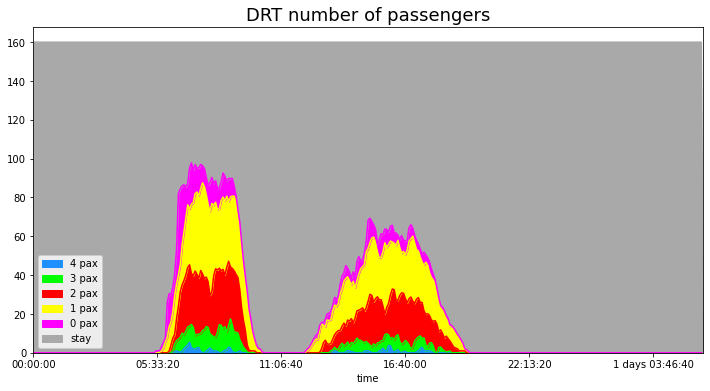

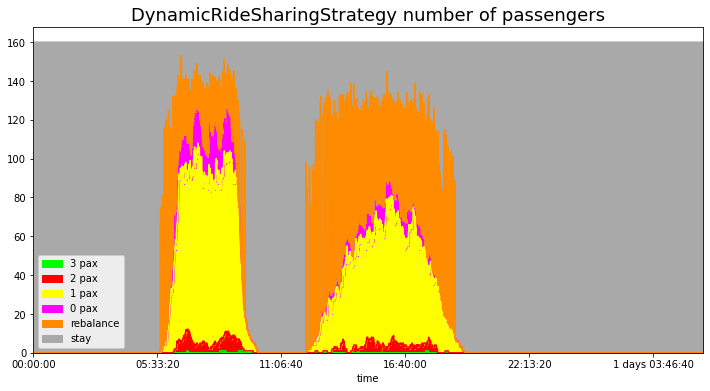

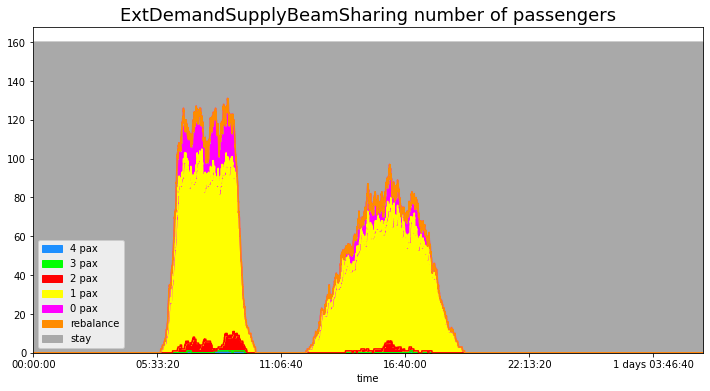

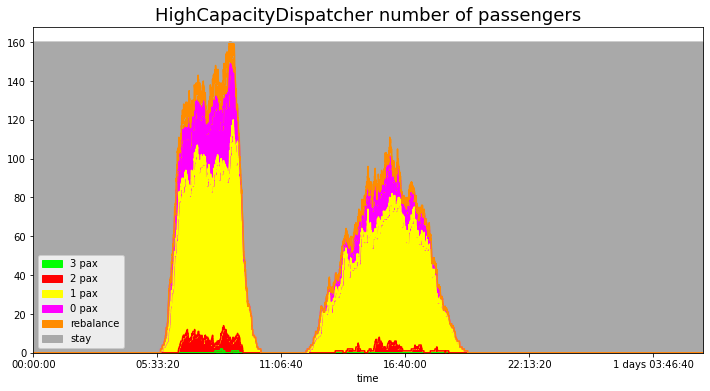

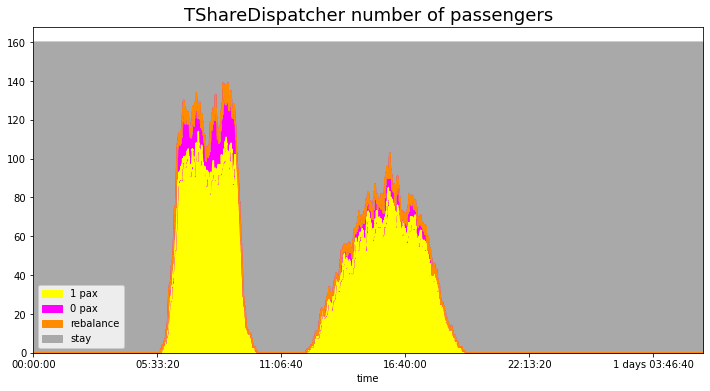

<Figure size 432x288 with 0 Axes>

In [40]:
axes = files.iterate_algorithms(PATH, occupancy.get_occupancy_graphs)
fig = plt.figure()
map(fig.add_axes, axes)
fig